In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

In [2]:
data_path = '/Users/crazeformarvel/Downloads/archive'

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

images_path = os.path.join(data_path, 'images')
masks_path = os.path.join(data_path, 'masks')

Original = os.listdir(images_path)
Masks = os.listdir(masks_path)

print("Number of images:", len(Original))
print("Number of masks:", len(Masks))

Number of images: 3064
Number of masks: 3064


In [9]:
X = np.zeros((len(Original), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(Masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

for file in Original:
    n = Original.index(file)
    path1 = os.path.join(images_path, file)
    img = cv2.imread(path1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    try:
        X[n] = img / 255.0
        file2 = Masks[n]
        path2 = os.path.join(masks_path, file2)
        mask = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.0  # Normalize the mask
        y[n] = mask
    except Exception as e:
        print(e)
        print("Error in:", path1)

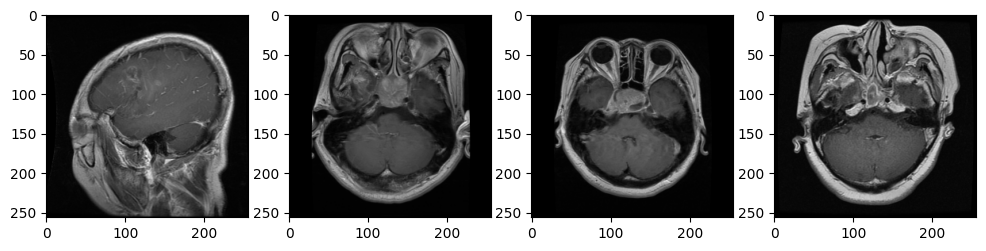

In [10]:
i = np.random.randint(1, 100)
plt.figure(figsize=(12, 15))
plt.subplot(141)
plt.imshow(X[i])
plt.subplot(142)
plt.imshow(X[i+1])
plt.subplot(143)
plt.imshow(X[i+2])
plt.subplot(144)
plt.imshow(X[i+3])
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
inputs = tf.keras.layers.Input((256, 256, 3))
s = inputs

# Contracting Path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive Path
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.2)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.2)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


77/77 ━━━━━━━━━━━━━━━━━━━━ 450s 6s/step - accuracy: 0.9820 - loss: 0.1945 - val_accuracy: 0.9825 - val_loss: 0.1060
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 434s 6s/step - accuracy: 0.9827 - loss: 0.0669 - val_accuracy: 0.9825 - val_loss: 0.0791
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 532s 7s/step - accuracy: 0.9827 - loss: 0.0594 - val_accuracy: 0.9825 - val_loss: 0.0635
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 564s 7s/step - accuracy: 0.9827 - loss: 0.0550 - val_accuracy: 0.9825 - val_loss: 0.0622
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 453s 6s/step - accuracy: 0.9826 - loss: 0.0488 - val_accuracy: 0.9825 - val_loss: 0.0583
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 481s 6s/step - accuracy: 0.9830 - loss: 0.0452 - val_accuracy: 0.9840 - val_loss: 0.0574
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - accuracy: 0.9870 - loss: 0.0371 - val_accuracy: 0.9850 - val_loss: 0.0426
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 412s 5s/step - accuracy: 0.9878 - loss: 0.0338 - val_accuracy: 0.9859 - val_loss: 0.

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Threshold predicted masks (sigmoid outputs)
y_pred_thresh = (y_pred > 0.5).astype(np.uint8)

# Flatten the arrays
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_thresh.flatten()

# Ensure both are of same dtype (optional, for extra safety)
y_true_flat = y_true_flat.astype(np.uint8)
y_pred_flat = y_pred_flat.astype(np.uint8)

# Evaluation metrics
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
print("Confusion Matrix:\n", conf_matrix)

precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
auc = roc_auc_score(y_true_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


Confusion Matrix:
 [[39150709   366303]
 [  191962   464594]]
Precision: 0.5591
Recall:    0.7076
F1 Score:  0.6247
AUC-ROC:   0.8492


In [17]:
model.save("//Users/crazeformarvel/Desktop/brain_tumor_segmentation_model.h5")


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("//Users/crazeformarvel/Desktop/confusion_matrix.png")
plt.close()


In [19]:
from sklearn.metrics import precision_recall_curve

# Generate precision-recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true_flat, y_pred.flatten())

# F1 Score for each threshold
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)

# Plot F1 score vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid()
plt.legend()
plt.savefig("//Users/crazeformarvel/Desktop/f1_curve.png")
plt.close()


In [20]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("//Users/crazeformarvel/Desktop/roc_curve.png")
plt.close()
